# Hands-On Autoencoders
We will continue to tackle our Credit Card Fraud problem but this time with neural networks via autoencoders

In [1]:
# Importing libararies
import numpy as np
import pandas as pd
import os, time, re, pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve
from sklearn.metrics import average_precision_score, roc_curve, auc, roc_auc_score

import lightgbm as lgb

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

/Users/diegomedina-bernal/miniconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


## 1. Data Preperation

In [2]:
data = pd.read_csv('./datasets/credit_card_data/credit_card_data.csv')

In [3]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
# Dropping class and time columns for our Data DF
data_X = data.copy().drop(['Class','Time'], axis=1)

# Just using Class for our Y data
data_y = data['Class'].copy()

# Scaling our data
features_to_scale = data_X.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
data_X.loc[:,features_to_scale] = sX.fit_transform(data_X[features_to_scale])

In [5]:
data_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


In [6]:
# number of classes
data_y.nunique()

2

In [7]:
# Creating our test and training set splits
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=2018, stratify=data_y)

In [8]:
X_train.shape

(190820, 29)

In [9]:
X_test.shape

(93987, 29)

In [10]:
y_train.shape

(190820,)

In [11]:
y_test.shape

(93987,)

In [12]:
# Creating another train and test set for our autoencoder 
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

## 1.1 Helper Functions & Plotting Functions
```anomaly_scores()``` will be a function to calculate the reconstruction error between the original feature matrix and the newly reconstructed feature matrix. 

This function takes the sum of squared errors and normalizes them to a range between zero and one. 

The transactions with errors close to one are the ones that are most anomalous (highest reconstruction error) and therefor, are most likely to be fraudulent. 

The transactions with errors close to zero have the lowest reconstruction error and are most likely to be normal

```plot_results``` will help us plot results allowing us to analyze the algorithm we utilize for our problem.

In [14]:
# anomaly scores function - loss function
def anomaly_scores(original_DF, reduced_DF):
    """
    ARGS:
        original_DF: the raw input
        reduced_DF : dataframe produced from encoder
    """
    loss = np.sum((np.array(original_DF) - np.array(reduced_DF))**2, axis=1)
    loss = pd.Series(data=loss, index=original_DF.index)
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    
    return loss

# Plotting function
def plot_results(true_labels, anomaly_scores_, return_preds=False):
    # creating predictions dataframe
    preds = pd.concat([true_labels, anomaly_scores_], axis=1)
    preds.columns = ['true_label', 'anomaly_score']
    
    # calculating precision recall curve
    precision, recall, threshold = precision_recall_curve(preds['true_label'], preds['anomaly_score'])
    
    # what is our average precision?
    average_precision = average_precision_score(preds['true_label'], preds['anomaly_score'])
    
    # creating our plot for precision recall curve
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'Precision Recall Curve: Average Precision: {average_precision}')
    
    # calculating roc_curve
    fpr, tpr, thresholds = roc_curve(preds['true_label'], preds['anomaly_score'])
    
    # area under ROC calculation
    area_under_ROC = auc(fpr, tpr)
    
    # plotting ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label="ROC Curve")
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic: Area under the curve: {area_under_ROC}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Returning predictions DF if called
    if return_preds == True:
        return preds, average_precision

## A. The Components of an Autoencoder and NN
Lets first go over basics of Autoencoders along with NN basics to understand what is happening under the hood. 

### Activation Functions
A neural network learns the weights to apply to the nodes at each of the layers but whether the nodes will be activated or not is determined by the activation function. 

In other words, an activation function is applied to the weighted input (plus bias) at each layer. (Weight input plus bias will be $Y$) 

The activation function takes in $Y$ and either activates (if $Y$ is above a certain threshold) or does not. 

If activated, the information in a given node is passed to the next layer; otherwise it is not. 

However, we do not want simple binary activations. Instead, we want a range of activation values. To do this, we can choose a linear activation function or a nonlinear activation function. 

The linear activation function is unbound. It can generate activation values between negative infinity and positive infinity. Common non-linear activation functions include: 

**Sigmoid Function**
The signmoid function is bounded and can generate activation values between zero and one.

**Tahn Function**
The tanh function is also bounded and can generate activation values between negative one and positive one. Its gradient is steeper than that of the sigmoid function

**ReLu Function**
The ReLu function has an interesting property. If Y is positive, ReLu will return Y. Otherwise it will return zero. Therefor, ReLu is unbounded for positive values of Y. 

This is also the least computationally expensive activation function

**Softmax Function**
The softmax function is used as the final activation function in a neural network for classification problems because it normalizes clafficiation probabilities to values that add up to a probability of one. 

## First Autoencoder
We will go through each line of building our first autoencoder step by step

In [30]:
# Model One - two layer complete autoencoder with linear activation
model = Sequential() # instantiate the model

##### Layer One - Encoder
Now we will specify the input shape by designating the number of dimension, which should match the number of dimensions in the original feature matrix

We will also specify the activation function known as the encoder function in this case, applied to the input layer and the number of nodes we want the hidden layer to have. 

For now, we will pass a *linear* as the activation function. 

In [33]:
# how many dimensions?
len(list(X_train.columns))

29

In [34]:
# Let's add the encoder layer
model.add(
    Dense(units=29, activation='linear', input_dim=29) # one dense layer
)

##### Layer Two - Decoder
Now we will add another layer (this is usually done all at once) to our model and will specify the activation function which will now be the decoder function applied to the hidden layer to *reconstruct* the observations and the number of dimensions we want the output layer to have. 

Since we want the final reconstructed matrix to have the same dimensions as the original matrix, the dimensions need to be 29, and we will use a linear activation function for the decoder as well

In [36]:
# Adding our decoder layer
model.add(
    Dense(units=29, activation='linear')
)

##### Compiling: Loss Function, Optimization, & Metric
We will now compile the layers and will be selecting a *loss function* also known as the *objective function*) to guide the learning of the weights. 

We will also select an *optimizer* to set the process by which the weights are learned.

Finally we will also select a list of *metric* to output to help us evaluate the goodness of the neural network. 

Let's dive into a bit of theory

### Loss Function
In our case, we are evaluating the model based on the reconstruction error between the newly reconstructed matrix of features based on the autoencoder and the original feature matrix that we feed into the autoencoder. 

We will be using the **mean squared error** as the evaluation metric. Specificy we will be using the sum of squared errors. 

### Optimizer
Neural networks train for many rounds (known as epochs). In each of these epochs, the neural network readjusts its learned weights to reduce its loss from the previous epoch. 

The process for learning these weights is set by the optimizer. We want a process that helps the neural network efficinetly learn the optimial weights for the various nodes across all the layers that minimize the loss function we have chosen. 

For the neural network to learn the optimal weights, the neural network needs to adjust its 'guess' for the optimal weights in an intelligent way. 

We will move the weights to minimize the cost function stochastically. 

This process is known as *stochastic gradient descent* or **SGD** for short. SGD has a single learning rate, known as *alpha*, for all the weight updates that it makes, and this learning rate does not change during training (though research show annealing this and momentum does create super convergence). 

An even better optimizer than SGD is *Adam Optimization Algorithn* which is derived from adaptive moment estimation. 

The Adam optimizer dynamically adjust the learning rate over the course of the training process. 

In [47]:
# Compiling 
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=['accuracy']
)

##### Training the Model
Next we will select the number of epochs and the batch size and finally begin our training process by calling ```fit```. 

The number of epochs determines the nunber of times the training occurs over the entire dataset we pass into the neural network. 

The batch sets the number of samples the neural network trains on before making the next gradient update. 

Into the fit method, we will pass the initial input matrix, X, and the target matrix, y. 

We will use ```X_train_AE```, because we want to compare the output of the autoencoder (reconstructed feature matrix) with the original feature matrix to calculate the reconstruction error

We will not use y given this is an unsupervised learning model. 

In [48]:
# Setting batch and epochs
num_epochs = 10
batch_size = 32

In [52]:
# Let's train our model
history = model.fit(
    x = X_train_AE, 
    y = X_train_AE, 
    epochs = num_epochs, 
    batch_size = batch_size, 
    shuffle = True, 
    validation_data = (X_train_AE, X_train_AE))

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 42us/step - loss: 0.0918 - acc: 0.8863 - val_loss: 0.0025 - val_acc: 0.9789
Epoch 2/10
190820/190820 [==============================] - 8s 40us/step - loss: 0.0010 - acc: 0.9917 - val_loss: 3.4977e-07 - val_acc: 0.9997
Epoch 3/10
190820/190820 [==============================] - 8s 40us/step - loss: 4.8418e-04 - acc: 0.9945 - val_loss: 4.4015e-06 - val_acc: 0.9992
Epoch 4/10
190820/190820 [==============================] - 8s 40us/step - loss: 7.0957e-04 - acc: 0.9945 - val_loss: 4.4264e-06 - val_acc: 0.9993
Epoch 5/10
190820/190820 [==============================] - 8s 41us/step - loss: 9.6364e-04 - acc: 0.9938 - val_loss: 7.9913e-06 - val_acc: 0.9994
Epoch 6/10
190820/190820 [==============================] - 8s 41us/step - loss: 5.4893e-04 - acc: 0.9942 - val_loss: 6.3797e-07 - val_acc: 0.9997
Epoch 7/10
190820/190820 [==============================] - 8s 40us/step - los

Our Neural network performed very bad overfitting the training data. This essentially formed an identity function opposed to generalizing. 

##### Evaluating on Test Set

93987/93987 [==============================] - 1s 7us/step


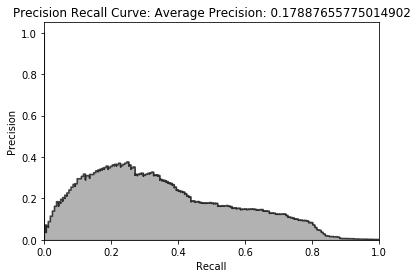

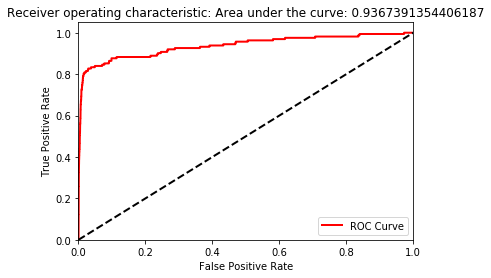

In [59]:
# Let's evaluate
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds = plot_results(y_test, anomaly_scores_AE, True) # Let's plot

## Two-Layer Undercomplete Autoencoder with Linear Activation Function
The only thing that will change for this experiment is the number of neurons in the hiddel layer. Instead of setting this to the number of original dimensions (29), we will set the numbers to 20. 

Therefor this will become a constrained autoencoder. The encoder function is forced to capture the information in the input layer with a fewer number of nodes, and the decoder has to take this new representation to reconstruct the original matrix. 

We will do 10 runs and compare

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/step - loss: 0.3402 - acc: 0.5235 - val_loss: 0.2779 - val_acc: 0.5558
Epoch 2/10
190820/190820 [==============================] - 7s 38us/step - loss: 0.2819 - acc: 0.5488 - val_loss: 0.2766 - val_acc: 0.5608
Epoch 3/10
190820/190820 [==============================] - 7s 37us/step - loss: 0.2800 - acc: 0.5615 - val_loss: 0.2759 - val_acc: 0.5631
Epoch 4/10
190820/190820 [==============================] - 7s 37us/step - loss: 0.2798 - acc: 0.5608 - val_loss: 0.2757 - val_acc: 0.5768
Epoch 5/10
190820/190820 [==============================] - 7s 37us/step - loss: 0.2790 - acc: 0.5728 - val_loss: 0.2754 - val_acc: 0.5710
Epoch 6/10
190820/190820 [==============================] - 7s 36us/step - loss: 0.2787 - acc: 0.5768 - val_loss: 0.2749 - val_acc: 0.5740
Epoch 7/10
190820/190820 [==============================] - 7s 36us/step - loss: 0.2775 - acc: 0.5710 - val_loss: 

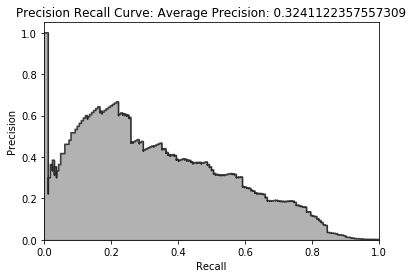

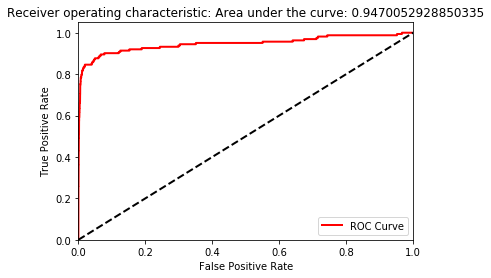

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 7s 39us/step - loss: 0.3371 - acc: 0.5170 - val_loss: 0.2794 - val_acc: 0.5383
Epoch 2/10
190820/190820 [==============================] - 7s 38us/step - loss: 0.2817 - acc: 0.5652 - val_loss: 0.2762 - val_acc: 0.5622
Epoch 3/10
190820/190820 [==============================] - 7s 37us/step - loss: 0.2798 - acc: 0.5665 - val_loss: 0.2754 - val_acc: 0.5716
Epoch 4/10
190820/190820 [==============================] - 7s 38us/step - loss: 0.2786 - acc: 0.5764 - val_loss: 0.2751 - val_acc: 0.5779
Epoch 5/10
190820/190820 [==============================] - 7s 38us/step - loss: 0.2780 - acc: 0.5901 - val_loss: 0.2752 - val_acc: 0.5779
Epoch 6/10
190820/190820 [==============================] - 7s 37us/step - loss: 0.2782 - acc: 0.5860 - val_loss: 0.2745 - val_acc: 0.5849
Epoch 7/10
190820/190820 [==============================] - 7s 37us/step - loss: 0.2779 - acc: 0.5924 - val_loss: 

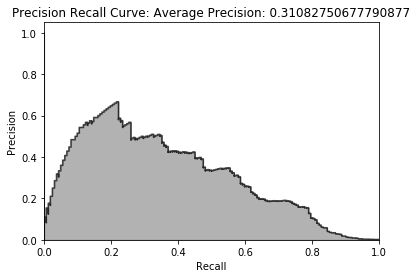

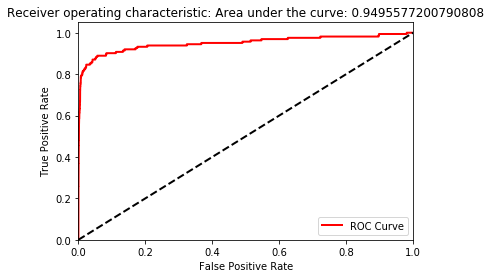

In [15]:
test_scores = []
for i in range(0,2):
    # we will train 10 times
    
    # instantiate our model
    model = Sequential()
    
    # Adding our layers
    model.add(Dense(units=20, activation='linear', input_dim=29)) # encoder
    model.add(Dense(units=29, activation='linear')) # decoder
    
    # compiling: loss, optimizer, metrics
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy'])
    
    # training the model: we will train 10 times, 10 epochs each
    num_epochs = 10
    batch_size = 32
    
    history = model.fit(
        x=X_train_AE,
        y=X_train_AE,
        epochs=num_epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_train_AE, X_train_AE),
        verbose=1)
    
    # Evaluating each run
    predictions = model.predict(X_test, verbose=1)
    anomaly_scores_AE = anomaly_scores(X_test, predictions)
    preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)
    
    # Adding to our test scores df
    test_scores.append(avg_precision)

In [17]:
np.mean(test_scores)

0.3174698712668198

##### Adding More Hidden Layers
Lets add hidden layers and see if this will perform better, we will continue to use linear activation functions

This will be a 3 layer network

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.1052 - acc: 0.7962 - val_loss: 0.0368 - val_acc: 0.8756
Epoch 2/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0416 - acc: 0.9207 - val_loss: 0.0365 - val_acc: 0.9052
Epoch 3/10
190820/190820 [==============================] - 8s 41us/step - loss: 0.0381 - acc: 0.9115 - val_loss: 0.0350 - val_acc: 0.9183
Epoch 4/10
190820/190820 [==============================] - 8s 42us/step - loss: 0.0377 - acc: 0.9219 - val_loss: 0.0344 - val_acc: 0.9321
Epoch 5/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.0363 - acc: 0.9434 - val_loss: 0.0372 - val_acc: 0.9433
Epoch 6/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0358 - acc: 0.9608 - val_loss: 0.0351 - val_acc: 0.9383
Epoch 7/10
190820/190820 [==============================] - 9s 45us/step - loss: 0.0363 - acc: 0.9377 - val_loss: 

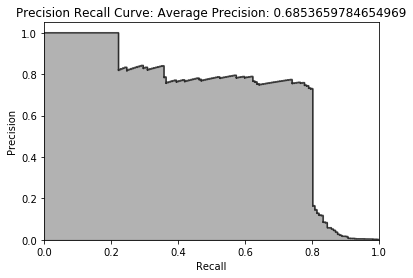

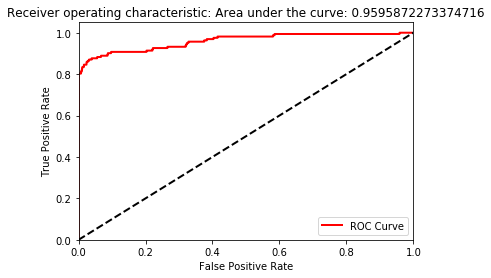

In [18]:
# Model Two
# Three Layer Undercomplete autoencoder with linear activation
model = Sequential()
model.add(Dense(units=28, activation='linear', input_dim=29))
model.add(Dense(units=27, activation='linear'))
model.add(Dense(units=29, activation='linear'))

# compiling: loss, optimizer, metrics
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy'])

# training the model: we will train 10 times, 10 epochs each
num_epochs = 10
batch_size = 32

history = model.fit(
    x=X_train_AE,
    y=X_train_AE,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE, X_train_AE),
    verbose=1)

# Evaluating each run
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

### Nonlinear Autoencoder
Now we will build an undercomplete autoencoder using a nonlinear activation function. 

We will have 3 hidden layers, with the first two layers representing our encoder and our next 2 layers representing our decoder which will attempt to reconstruct the output of layer 3

We will also use a relu activation function (non linear)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 51us/step - loss: 0.6755 - acc: 0.6416 - val_loss: 0.6089 - val_acc: 0.7899
Epoch 2/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.6013 - acc: 0.8031 - val_loss: 0.5920 - val_acc: 0.8320
Epoch 3/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.5888 - acc: 0.8365 - val_loss: 0.5848 - val_acc: 0.8360
Epoch 4/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.5856 - acc: 0.8468 - val_loss: 0.5850 - val_acc: 0.8411
Epoch 5/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.5842 - acc: 0.8498 - val_loss: 0.5837 - val_acc: 0.8503
Epoch 6/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.5860 - acc: 0.8460 - val_loss: 0.5858 - val_acc: 0.8520
Epoch 7/10
190820/190820 [==============================] - 10s 50us/step - loss: 0.5842 - acc: 0.8510 - val_loss

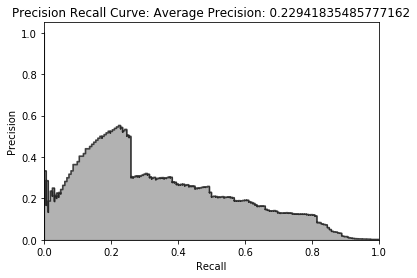

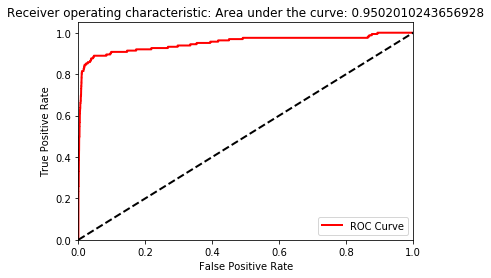

In [19]:
model = Sequential()
model.add(Dense(units=27, activation='relu', input_dim=29))
model.add(Dense(units=22, activation='relu'))
model.add(Dense(units=27, activation='relu'))
model.add(Dense(units=29, activation='relu'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

# training the model: we will train 10 times, 10 epochs each
num_epochs = 10
batch_size = 32

history = model.fit(
    x=X_train_AE,
    y=X_train_AE,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE, X_train_AE),
    verbose=1)

# Evaluating each run
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

### Overcomplete Autoencoder with Linear Activation
Now we will attempt this with an overcomplete autoencoder. Overcomplete autoencoders have more nodes in the hidden layer than either the input pr output layer. 

Because the capacity of the neural network is so high, the autoencoder simply memorizes the observations it trains on. 

Let's see what happens

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 42us/step - loss: 0.0538 - acc: 0.9325 - val_loss: 3.4928e-05 - val_acc: 0.9963
Epoch 2/10
190820/190820 [==============================] - 8s 41us/step - loss: 0.0011 - acc: 0.9929 - val_loss: 1.8989e-06 - val_acc: 0.9995
Epoch 3/10
190820/190820 [==============================] - 8s 41us/step - loss: 7.6396e-04 - acc: 0.9932 - val_loss: 0.0103 - val_acc: 0.9668
Epoch 4/10
190820/190820 [==============================] - 8s 41us/step - loss: 0.0010 - acc: 0.9934 - val_loss: 0.0025 - val_acc: 0.9786
Epoch 5/10
190820/190820 [==============================] - 8s 41us/step - loss: 6.2497e-04 - acc: 0.9934 - val_loss: 1.7150e-05 - val_acc: 0.9984
Epoch 6/10
190820/190820 [==============================] - 8s 40us/step - loss: 6.8064e-04 - acc: 0.9934 - val_loss: 7.2935e-06 - val_acc: 0.9989
Epoch 7/10
190820/190820 [==============================] - 8s 40us/step - loss: 9.816

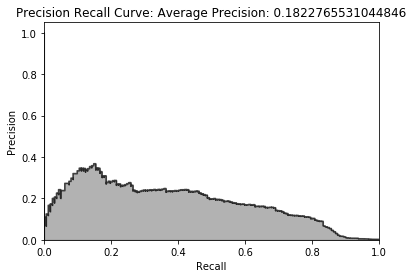

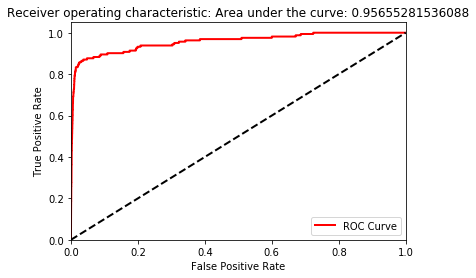

In [20]:
model = Sequential()
model.add(Dense(units=40, activation='linear', input_dim=29))
model.add(Dense(units=29, activation='linear'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

num_epochs = 10
batch_size = 32

history = model.fit(
    x=X_train_AE,
    y=X_train_AE,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE,X_train_AE),
    verbose=1)

# Evaluating each run
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

### Overcomplete Autoencoder with Linear Activation and Dropout
One way to improve the overcomplete autoencoder solution is to use a regularization technique to reduce the overfitting. 

One such technique is known as *dropout*. With dropout we force the autoencoder to drop out some defined percentage of units from the layers in the neural network. 

Therefor the autoencoder will have to generalize a bit more. The autoencoder is forced to learn more of the salient features in the dataset and lose some of the less salient information. 

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.1386 - acc: 0.7382 - val_loss: 0.0119 - val_acc: 0.9637
Epoch 2/10
190820/190820 [==============================] - 9s 45us/step - loss: 0.0774 - acc: 0.7867 - val_loss: 0.0077 - val_acc: 0.9745
Epoch 3/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.0776 - acc: 0.7872 - val_loss: 0.0070 - val_acc: 0.9792
Epoch 4/10
190820/190820 [==============================] - 9s 45us/step - loss: 0.0772 - acc: 0.7836 - val_loss: 0.0067 - val_acc: 0.9822
Epoch 5/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.0771 - acc: 0.7855 - val_loss: 0.0069 - val_acc: 0.9739
Epoch 6/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0766 - acc: 0.7874 - val_loss: 0.0101 - val_acc: 0.9714
Epoch 7/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0779 - acc: 0.7866 - val_loss: 

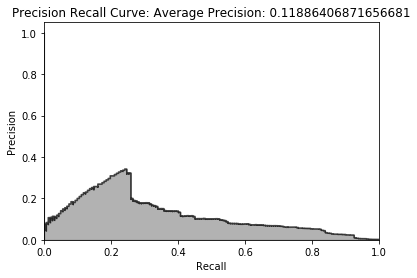

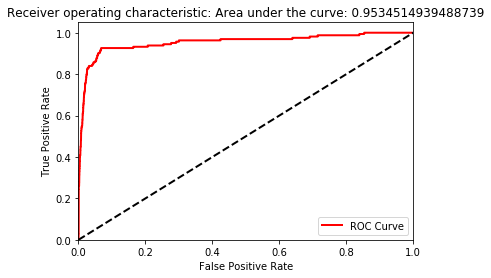

In [21]:
model = Sequential()
model.add(Dense(units=40, activation='linear', input_dim=29))
model.add(Dropout(0.10)) # 10%
model.add(Dense(units=29, activation='linear'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

num_epochs = 10
batch_size = 32

history = model.fit(
    x=X_train_AE,
    y=X_train_AE,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE,X_train_AE),
    verbose=1)

# Evaluating each run
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

### Sparse Overcomplete Autoencoder with Linear Activation
Another regularization technique is *sparsity*. We can force the autoencoder to take the sparsity of the matrix into consideration such that the majority of the autoencoder's neurons are inactive most of the time (not firing). 

This makes it harder for the autoencoder to memorize the identity function even when the autoencoder is over complete because most of the nodes cannot fire and, therefor, cannot overfit the observations as easily

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 45us/step - loss: 0.1192 - acc: 0.9233 - val_loss: 0.0363 - val_acc: 0.9735
Epoch 2/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0292 - acc: 0.9839 - val_loss: 0.0217 - val_acc: 0.9949
Epoch 3/10
190820/190820 [==============================] - 9s 45us/step - loss: 0.0228 - acc: 0.9805 - val_loss: 0.0470 - val_acc: 0.9483
Epoch 4/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.0193 - acc: 0.9800 - val_loss: 0.0148 - val_acc: 0.9935
Epoch 5/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0214 - acc: 0.9816 - val_loss: 0.0280 - val_acc: 0.9536
Epoch 6/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0170 - acc: 0.9798 - val_loss: 0.0164 - val_acc: 0.9642
Epoch 7/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0178 - acc: 0.9778 - val_loss: 

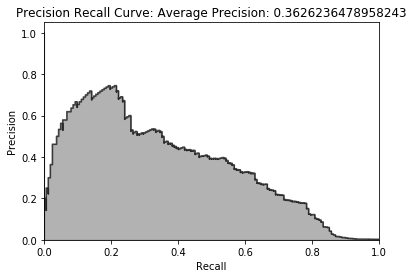

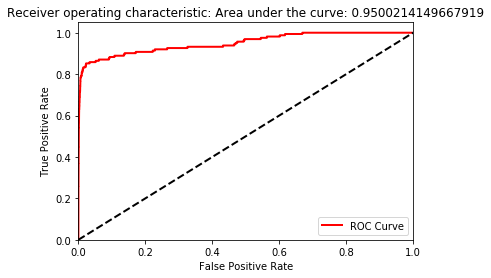

In [22]:
model = Sequential()
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29)) # added sparsity (l1 regularization)
model.add(Dense(units=29, activation='linear'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

num_epochs = 10
batch_size = 32

history = model.fit(
    x=X_train_AE,
    y=X_train_AE,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE,X_train_AE),
    verbose=1)

# Evaluating each run
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

### Sparse Overcomplete Autoencoder with Linear Activation and Dropout
Let's combine both regularization techniques

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.1649 - acc: 0.8101 - val_loss: 0.0495 - val_acc: 0.9834
Epoch 2/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0767 - acc: 0.8627 - val_loss: 0.0345 - val_acc: 0.9818
Epoch 3/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0696 - acc: 0.8627 - val_loss: 0.0317 - val_acc: 0.9631
Epoch 4/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0655 - acc: 0.8600 - val_loss: 0.0265 - val_acc: 0.9749
Epoch 5/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0656 - acc: 0.8607 - val_loss: 0.0271 - val_acc: 0.9692
Epoch 6/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.0608 - acc: 0.8604 - val_loss: 0.0220 - val_acc: 0.9850
Epoch 7/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0620 - acc: 0.8591 - val_loss: 

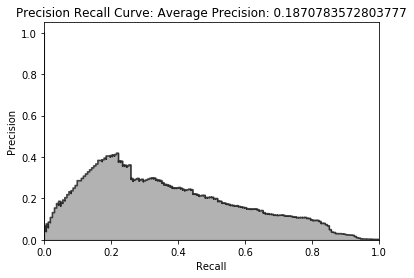

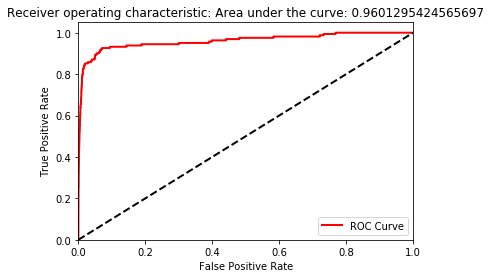

In [23]:
model = Sequential()
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29)) # sparsity
model.add(Dropout(0.05)) # dropout 5%
model.add(Dense(units=29, activation='linear'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

num_epochs = 10
batch_size = 32

history = model.fit(
    x=X_train_AE,
    y=X_train_AE,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE,X_train_AE),
    verbose=1)

# Evaluating each run
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

### Experiment Conclusions
Our best yet had been ~50% average precision with a shallow network utilizing a linear activation function. 

What I would further do is include momentum and finding the optimil learning rate annealing. 

What may be happening here is that our gradients may be getting stuck at a local minimum, therefor an annealing momemtum and learning rate should fix this issue. 

Further experiments, I would increase the complexity of the network. That is include more hidden layers with more nodes (over complete). 

And find the optimial hyper-parameters & regularizations. 

I would experiment with: Dropout, Sparsity, Momentum ranges, Weight Decay, Batch Size. 

Another trick may also to use a pre-prained autoencoder if this exist (trained on similar dataset.

## Working with Noise Datasets
A common problem with real-world data is noisiness data is often distorted in some way because of data quality issues from data capture, data migration, data transformation, etc. 

We need autoencoders to be robust enough against noise so that they are not fooled and can learn from the truly important underling stucture in the data. 

Let's simulate some noise data.

In [26]:
noise_factor = 0.50

X_train_AE_noisy = X_train_AE.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)

X_test_AE_noisy = X_test_AE.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape)

## Denoising Autoencoder
Compared to the original, nondistored dataset, the penalty for overfitting to the noisy dataset of credict card transactions is much higher. 

There is enough noise in the dataset that an autoencoder that fits too well to the noise data will have a poor time detecting fraudulent transactions from normal ones. 

### Two-Layer Denoising Undercomplete Autoencoder with Linear Activation
Lets test this model

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.1377 - acc: 0.7791 - val_loss: 0.0362 - val_acc: 0.9008
Epoch 2/10
190820/190820 [==============================] - 8s 41us/step - loss: 0.0565 - acc: 0.8759 - val_loss: 0.0440 - val_acc: 0.9092
Epoch 3/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0551 - acc: 0.8772 - val_loss: 0.0348 - val_acc: 0.9194
Epoch 4/10
190820/190820 [==============================] - 8s 42us/step - loss: 0.0538 - acc: 0.8789 - val_loss: 0.0347 - val_acc: 0.9301
Epoch 5/10
190820/190820 [==============================] - 8s 42us/step - loss: 0.0549 - acc: 0.8874 - val_loss: 0.0343 - val_acc: 0.9319
Epoch 6/10
190820/190820 [==============================] - 12s 60us/step - loss: 0.0530 - acc: 0.8829 - val_loss: 0.0345 - val_acc: 0.9488
Epoch 7/10
190820/190820 [==============================] - 8s 42us/step - loss: 0.0527 - acc: 0.8885 - val_loss:

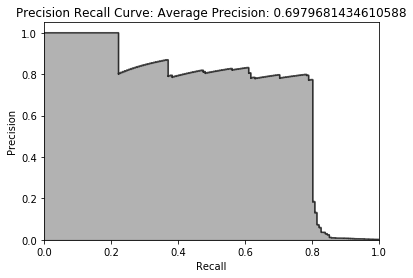

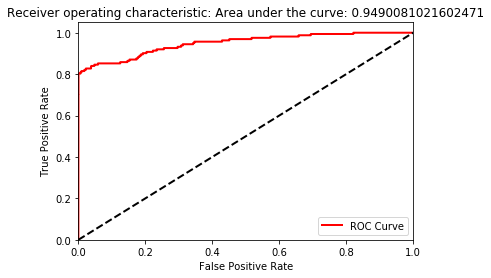

In [28]:
# instantiating
model = Sequential()

# Layers
model.add(Dense(units=27, activation='linear', input_dim=29))
model.add(Dense(units=29, activation='linear'))

# Loss, optimizer, metric
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

# epochs, batch size
num_epochs = 10
batch_size = 32

# Training
history = model.fit(
    x=X_train_AE_noisy,
    y=X_train_AE_noisy,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE, X_train_AE),
    verbose=1)

# Evaluating
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

# resetting model
model.reset_states()

### Two-Layer Denoising Overcomplete Autoencoder with Linear Activation
We will add l1 regularization (sparsity), dropout, one hidden layer.

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 51us/step - loss: 0.1782 - acc: 0.7994 - val_loss: 0.0456 - val_acc: 0.9824
Epoch 2/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.0895 - acc: 0.8478 - val_loss: 0.0322 - val_acc: 0.9817
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0796 - acc: 0.8463 - val_loss: 0.0261 - val_acc: 0.9823
Epoch 4/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0751 - acc: 0.8456 - val_loss: 0.0254 - val_acc: 0.9717
Epoch 5/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0731 - acc: 0.8446 - val_loss: 0.0217 - val_acc: 0.9785
Epoch 6/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.0726 - acc: 0.8430 - val_loss: 0.0196 - val_acc: 0.9810
Epoch 7/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.0716 - acc: 0.8449 - val_lo

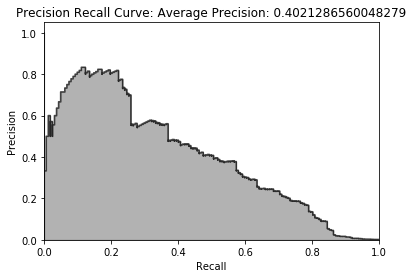

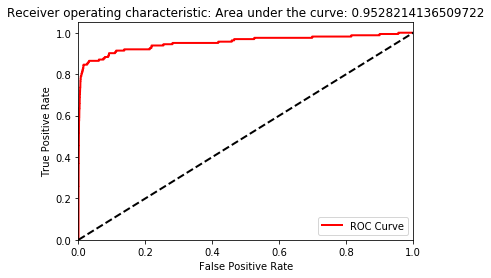

In [29]:
model = Sequential()

model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29))
model.add(Dropout(0.05))
model.add(Dense(units=29, activation='linear'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

# epochs, batch size
num_epochs = 10
batch_size = 32

# Training
history = model.fit(
    x=X_train_AE_noisy,
    y=X_train_AE_noisy,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE, X_train_AE),
    verbose=1)

# Evaluating
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

# resetting model
model.reset_states()

### Two-Layer Denoising Overcomplete Autoencoder with ReLU (non-linear)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 50us/step - loss: 0.8590 - acc: 0.5917 - val_loss: 0.5928 - val_acc: 0.8010
Epoch 2/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.7410 - acc: 0.7436 - val_loss: 0.5512 - val_acc: 0.8930
Epoch 3/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.7053 - acc: 0.8321 - val_loss: 0.5378 - val_acc: 0.9275
Epoch 4/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.6938 - acc: 0.8655 - val_loss: 0.5341 - val_acc: 0.9388
Epoch 5/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.6923 - acc: 0.8632 - val_loss: 0.5355 - val_acc: 0.9229
Epoch 6/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.6897 - acc: 0.8653 - val_loss: 0.5319 - val_acc: 0.9399
Epoch 7/10
190820/190820 [==============================] - 9s 50us/step - loss: 0.6893 - acc: 0.8640 - val_loss:

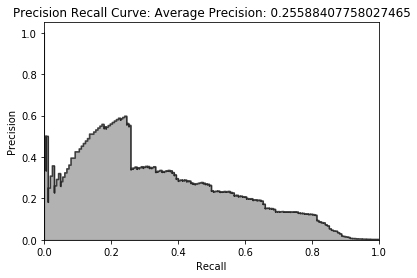

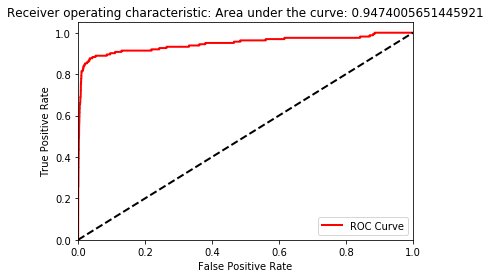

In [31]:
model = Sequential()

model.add(Dense(units=40, activation='relu', activity_regularizer=regularizers.l1(10e-5), input_dim=29))
model.add(Dropout(0.05))
model.add(Dense(units=29, activation='relu'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

# epochs, batch size
num_epochs = 10
batch_size = 32

# Training
history = model.fit(
    x=X_train_AE_noisy,
    y=X_train_AE_noisy,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_train_AE, X_train_AE),
    verbose=1)

# Evaluating
predictions = model.predict(X_test, verbose=1)
anomaly_scores_AE = anomaly_scores(X_test, predictions)
preds, avg_precision = plot_results(y_test, anomaly_scores_AE, True)

# resetting model
model.reset_states()